# Training Generative Adversarial Networks (GANs) in PyTorch

### Part 7 of "Deep Learning with Pytorch: Zero to GANs"

This tutorial series is a hands-on beginner-friendly introduction to deep learning using [PyTorch](https://pytorch.org), an open-source neural networks library. These tutorials take a practical and coding-focused approach. The best way to learn the material is to execute the code and experiment with it yourself. Check out the full series here:

1. [PyTorch Basics: Tensors & Gradients](https://jovian.ai/aakashns/01-pytorch-basics)
2. [Gradient Descent & Linear Regression](https://jovian.ai/aakashns/02-linear-regression)
3. [Working with Images & Logistic Regression](https://jovian.ai/aakashns/03-logistic-regression) 
4. [Training Deep Neural Networks on a GPU](https://jovian.ai/aakashns/04-feedforward-nn)
5. [Image Classification using Convolutional Neural Networks](https://jovian.ai/aakashns/05-cifar10-cnn)
6. [Data Augmentation, Regularization and ResNets](https://jovian.ai/aakashns/05b-cifar10-resnet)
7. [Generating Images using Generative Adversarial Networks](https://jovian.ai/aakashns/06b-anime-dcgan/)


### Using a GPU for faster training

You can use a [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU) to train your models faster if your execution platform is connected to a GPU manufactured by NVIDIA. Follow these instructions to use a GPU on the platform of your choice:



# Introduction to Generative Modeling

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

To get a sense of the power of generative models, just visit [thispersondoesnotexist.com](https://thispersondoesnotexist.com). Every time you reload the page, a new image of a person's face is generated on the fly. The results are pretty fascinating:

<img src="https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png" style="width:480px; margin-bottom:32px"/>

While there are many approaches used for generative modeling, a Generative Adversarial Network takes the following approach: 

<img src="https://i.imgur.com/6NMdO9u.png" style="width:420px; margin-bottom:32px"/>

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. 

At first we train the discriminator to be able to distinguish between really bad generated images and actual images from the dataset. Then keeping the discriminator fixed , we train the generator to generate a slightly better images that can fool the discriminator. So now the generator gets better at every time then we train the discriminator once again that it can better once again in diffrentiatiing a better fake images vs the real image and this cycle is repeated batch by batch or cycle by cycle.

GANs are called so becoz the generator and the discriminator are like adveseries. Generator tries to fool the discriminator whereas the discriminator tries to catch the generator by detectin its fake images.

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. In this tutorial, we'll train a GAN to generate images of anime characters' faces.

<img src="https://i.imgur.com/NaKtJs0.png" width="360" style="margin-bottom:32px"/>


We'll use the [Anime Face Dataset](https://github.com/Mckinsey666/Anime-Face-Dataset), which consists of over 63,000 cropped anime faces. Note that generative modeling is an unsupervised learning task, so the images do not have any labels. Most of the code in this tutorial is based [on this notebook](https://www.kaggle.com/splcher/starter-anime-face-dataset). 

In [5]:
project_name = 'anime-dcgan'

## Downloading and Exploring the Data

We can use the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/splcher/animefacedataset) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle.  Follow these steps to find your API credentials:

1. Sign in to  [https://kaggle.com/](https://kaggle.com),  then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file `kaggle.json` with the following contents:

```
{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
```

3. When you run `opendatsets.download`, you will be asked to enter your username & Kaggle API, which you can get from the file downloaded in step 2.

Note that you need to download the `kaggle.json` file only once. On Google Colab, you can also upload the `kaggle.json` file using the files tab, and the credentials will be read automatically.


In [6]:
!pip install opendatasets --upgrade --quiet

In [9]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  sushanttwayana


Your Kaggle Key:

  ································


100%|██████████| 395M/395M [00:15<00:00, 27.3MB/s] 


The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [11]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [13]:
print(os.listdir(DATA_DIR+'/images')[:10])

['46015_2014.jpg', '3165_2002.jpg', '24163_2008.jpg', '6443_2003.jpg', '46421_2014.jpg', '62865_2019.jpg', '55677_2016.jpg', '13375_2005.jpg', '22039_2008.jpg', '30777_2010.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

We are going to pick the mean and SD of 0.5. Here the purpose is not actually normalize the pixels across the channels but the purpose is to take the values which have pixels intesnity 0 to 1 and translate them into -1 to 1. It is more convininet to train the discriminator when the pixel values are from -1 to 1 which is if they are symetrically distributed around 0 rather than being in 0 to 1. So the normalization values is not actually to change the effect of differnt channels .This is to move pixel intensities values from 0-1 to -1,1 range.

In [16]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [17]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [18]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [20]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [23]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

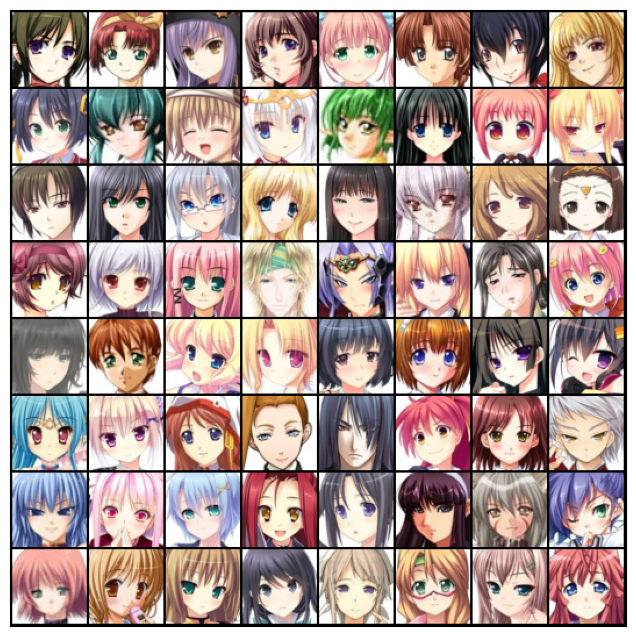

In [24]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [27]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [31]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

We give a image which is 3 channel with 64/64 px and for this image the discriminator returns a single value O/P. And we will interpret this number as the probability that discriminator thinks the input image was drawn from actual dataset. If the discriminator outputs 0 then it concludes that the image was generated by the generator and if the output is near to 1 or 0.9 then it is 90% sure that the input image was drawn from the real datset. This type of classification is reffered as a binary data classification. So a straight forward convolutional neural network is going to be used so we don't need to extend any classes here we can simply use nn.Sequential class. 

In [33]:
import torch.nn as nn

In [34]:
discriminator = nn.Sequential(
    # in: bs x 3 x 64 x 64
    
    # kernel size of 4 is so that we are covering evry pixels properly.
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    # y =ax where a = 0.2 for out<=0
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

The sigmoid function will convert any large positive numbers into range of (0.5-1) whearas negative numbers end up to range(0-0.5). We use sigmoid function as we want to interpret the output of the discriminator which is a single number per image and interpret it as a probability and the probability to find the passed in image was a real image or the generated fake image.


Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

The idea here is the images generated from the generator, we want to make sure that once the image is generated by the generator none of the image information is lost as we are passing it into the discriminator & using a loss func to train the generator.

Let's move the discriminator model to the chosen device.

In [35]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

Takes a random tensor and convert that into an image, an different random tensor will give us diff image. The idea is to change the weights of the generator so that each time we get a random tensor the image that comes out looks like the actual image drawn from actual datasets.To do this i.e go from 128/1 to shape 3/28 we need to do the reverse of the convolution.

Suppose we have a 3/3 image (the blue square represents the pixel of the img)and we pad it, not just around the image but also between the pixels. Then we take a 3/3 kernel and we run it over the 3/3 feature map. Now as we run the kernel from 3/3 kernel we end up with 5/5 image in the above case.

In [36]:
latent_size = 128

The basic idea behind the latent size is that if you had just one vector then you would have just one dimensional control over the vector. We can think different latent vectors are controlling diff aspects of the generated image. Maybe the 1st element of latent vector may end up controlling the color of the hair, 2nd element latent vector may end up with controllig the color of the eyes, 3rd may control the shape of the mouth, 4th which way the face is turning and so on.

Its surfacely that some of the elements of the latent vector controls the attributes of the generated image once the generator is trained. So more the latent vectors we have the more varities we can get in our generated images. Typically like 64 or 128 images are good enough for simpler images . For more detailed images like human face we may or must use bigger latent size.

We 1st increase the channels to 512 and feature map increased to 4/4 and double the feature map but decrease the channels by half. Finally the final layer will take the 64 channels and output it as a 3 channels.

The end result of the generator is to take a latent size of 128 x 1 x 1 and convert it to 3x 64 x64 image 

In [37]:
generator = nn.Sequential(
    # batch of latent tensor
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # for generator we use only ReLU
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We use the TanH activation function for the output layer of the generator.
The TanH reduces the values to -1 to 1.
The O/P of the generator can have any values ranging from -infinity to +infinity so this activation function reduces each values to the range of -1 to 1 so that the final generated image pixels values is within the fixed range.

Now if we recall when we created our dataset, we applied a normalization which converts the real image from 0 to 1 pixel intensities into the pixel values of range -1 to +1. Thus we can see how all these fits together that the input dataset px intensities value and generator generated images are both 3 x 64 x 64. We trained the generator to generate the images at least so that the generated images have the px intensities in the range of real  images. The next step will be to train the generator further so that not only the px intensities value matches but even the pxs have such values that when we put all pixels together it relly looks like the real img.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


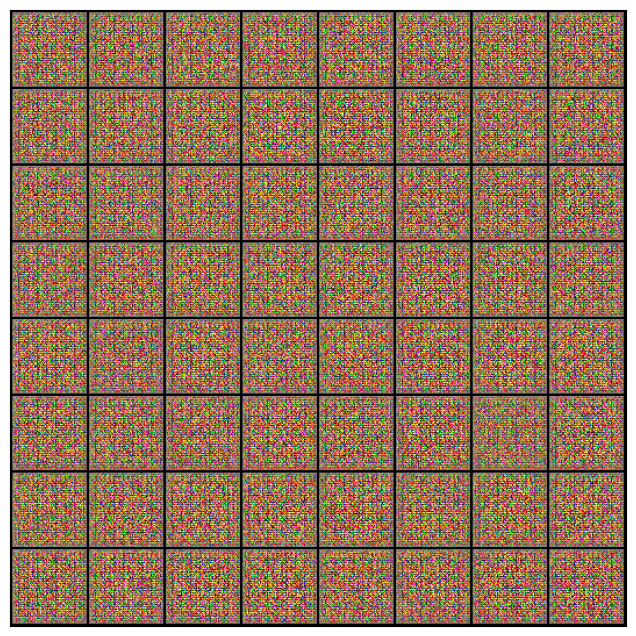

In [38]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors of -1 to 1
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [39]:
generator = to_device(generator, device)

## Discriminator Training
First we will train the discriminator and use the discriminator to train the generator.

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

opt_d -> set up to modify the parameters of the discriminator

opt_d.step() -> discriminator optimizer-> modify the weights of discriminator make them 
slightly better so that the discriminator is slightly better in detecting the fake images

In [41]:
# on batch of inputs
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    # evaluation matrix
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    # computes the gradient of the loss w.r.t every single weights of the discriminator
    loss.backward()
    opt_d.step() # discriminator optimizer-> modify the weights of discriminator make them 
    # slightly better so that the discriminator is slightly better in detecting the fake images
    return loss.item(), real_score, fake_score

* Pass real images through discriminator

We take the batch of real images and pass them through the discriminator and we get the set of predictions. For each imgs we will get the O/P as a single number i.e. if we pass the batch of 128 images then it will output 128 numbers, each of them within the range of 0-1. 
But what we really want the discriminator to predict is the target for the real images(1),so it should be prediciting 1 for the real images where the prob that the real images is 1.

* Generate fake images

Also we need to pass a batch of fake images so that the discriminator could classify which of the images is fake. Then again we create a batch of latent tensors, using random batch which results into batch of latent tensor of  128x1 x1 which is then pass into the generator to generate the fake images having exact shape of real images but initally it would just be a pixels with random noise.

* Pass fake images through discriminator

So we take all of these fake images and for these fake images the target should be 0. The discriminator should be predicting the prob of these images to be real is 0 and the predicition for the fake images can be passed by simply passing it into the discriminator.
So, we pass the fake images into the discriminator gets some prediction and the targets are all set to zero which is done using torch.zeros()





Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator and outcomes some prediitons.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

We can see that the discriminator is the part of the loss func and thus we are using the discriminator as a func not a neural net to convert the imgs into the numbers and we want those numbers to be as close to 1 as possible to make the generator better

In [42]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    # loss for generator
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

We are going to save the intermediate outputs after every epochs we are going to generate the images and we are going to save those batch of images as file(png)

In [43]:
from torchvision.utils import save_image

In [44]:

# directory generated
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [45]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    # saves the images as a format of 0000.png, 00001.png
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    
    # converts the batch of images into grid and saves that as a file png 
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

So let's create a set of fixed latent tensor that we can keep using after each epochs because we want to look at the output of our model. So it would be good to look the outputs at the same set of tensors, otherwise if we change the set of latent tensors we may not be able to compare the performance of the model epochs after epochs

In [46]:
# 64 is used so that we can display it as  8 x 8 image not 128
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


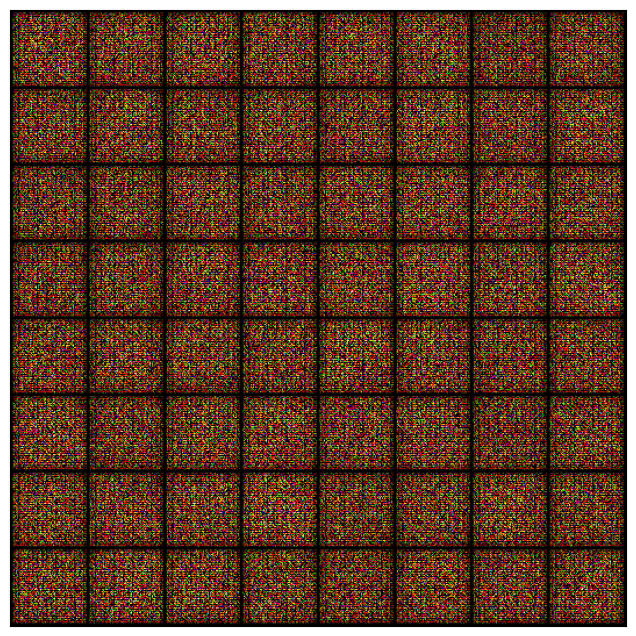

In [47]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [48]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

We are going to create two optimizer one for the genertor and another for the discriminator.

* The discriminator opt is going to change the weights of the discriminator
* The generator opt is going to change the weights of the generator

tqdm is a helper library used to show the progress bar for the each epochs

In [49]:
# start_idx is used to save the images after each epochs
def fit(epochs, lr, start_idx=1):
    # removes any unused data from the memory for fresh memory start
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        # Here we pass the same fixed_latent tensor so that at the end of each epoch we
        #  generate the set of images using the same latent tensor
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

For each batch we train the discriminator, so we pass the batch of real images and optimizer. Note that we are not reallu intrested in the target that we get from the original image dataset infact there is only one class or one folder given to the imagefolder. So there are no labels that we can use for the datas.

Then we are going to train the generator simply by passing the optimizer. It is going to generate some fake images, which is then passed through the discriminator setting the target to 1 calculate the loss and then update the weights of the generator. 

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [52]:
lr = 0.0002
epochs = 40

In [53]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 5.1247, loss_d: 0.4509, real_score: 0.8485, fake_score: 0.2134
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 4.3722, loss_d: 0.3791, real_score: 0.7731, fake_score: 0.0628
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 5.5802, loss_d: 0.5341, real_score: 0.8615, fake_score: 0.2723
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 6.3232, loss_d: 0.3854, real_score: 0.8832, fake_score: 0.1992
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 7.1073, loss_d: 0.3290, real_score: 0.9561, fake_score: 0.2246
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.1831, loss_d: 0.1000, real_score: 0.9293, fake_score: 0.0151
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 5.1899, loss_d: 0.0386, real_score: 0.9825, fake_score: 0.0187
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 8.9974, loss_d: 0.9321, real_score: 0.9996, fake_score: 0.4561
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.2825, loss_d: 0.2051, real_score: 0.8536, fake_score: 0.0252
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 3.3417, loss_d: 0.1203, real_score: 0.9066, fake_score: 0.0148
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 7.4587, loss_d: 0.2157, real_score: 0.9820, fake_score: 0.1649
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 5.9073, loss_d: 0.1761, real_score: 0.9810, fake_score: 0.1362
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.5485, loss_d: 0.1428, real_score: 0.9509, fake_score: 0.0789
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.5089, loss_d: 0.1036, real_score: 0.9701, fake_score: 0.0668
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 6.5197, loss_d: 0.2418, real_score: 0.9904, fake_score: 0.1888
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 3.6836, loss_d: 0.1274, real_score: 0.9289, fake_score: 0.0459
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 5.0125, loss_d: 0.1102, real_score: 0.9691, fake_score: 0.0709
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.7504, loss_d: 0.1039, real_score: 0.9671, fake_score: 0.0647
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 3.8854, loss_d: 0.0505, real_score: 0.9774, fake_score: 0.0254
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 4.6585, loss_d: 0.0960, real_score: 0.9646, fake_score: 0.0545
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 3.8684, loss_d: 0.4620, real_score: 0.8739, fake_score: 0.2026
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.6614, loss_d: 0.0701, real_score: 0.9493, fake_score: 0.0151
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 3.6445, loss_d: 0.0928, real_score: 0.9429, fake_score: 0.0276
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 3.5883, loss_d: 0.0757, real_score: 0.9846, fake_score: 0.0546
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 0.4823, loss_d: 5.7568, real_score: 0.0072, fake_score: 0.0001
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 5.0177, loss_d: 0.2094, real_score: 0.9726, fake_score: 0.1458
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 5.1438, loss_d: 0.2092, real_score: 0.9777, fake_score: 0.1580
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 4.1827, loss_d: 0.1564, real_score: 0.9590, fake_score: 0.0975
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 5.4918, loss_d: 0.0821, real_score: 0.9784, fake_score: 0.0513
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 2.9484, loss_d: 0.1727, real_score: 0.9720, fake_score: 0.1196
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 5.5848, loss_d: 0.0569, real_score: 0.9917, fake_score: 0.0450
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 4.2780, loss_d: 0.0609, real_score: 0.9754, fake_score: 0.0340
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 4.5557, loss_d: 0.1235, real_score: 0.9551, fake_score: 0.0684
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 5.3882, loss_d: 0.0256, real_score: 0.9934, fake_score: 0.0185
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 3.7955, loss_d: 0.1129, real_score: 0.9207, fake_score: 0.0224
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 4.5074, loss_d: 0.0632, real_score: 0.9699, fake_score: 0.0293
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.4551, loss_d: 0.0454, real_score: 0.9726, fake_score: 0.0161
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 5.9186, loss_d: 0.0500, real_score: 0.9754, fake_score: 0.0231
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 4.7290, loss_d: 0.0265, real_score: 0.9808, fake_score: 0.0059
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 4.4277, loss_d: 0.1183, real_score: 0.9245, fake_score: 0.0316
Saving generated-images-0040.png


In [54]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

In [59]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [60]:
from IPython.display import Image

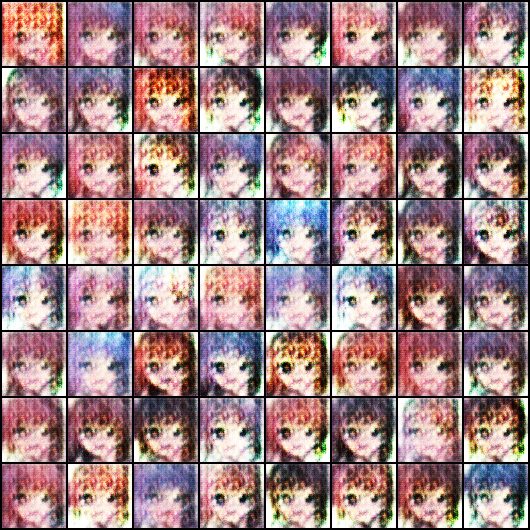

In [61]:
Image('./generated/generated-images-0001.png')

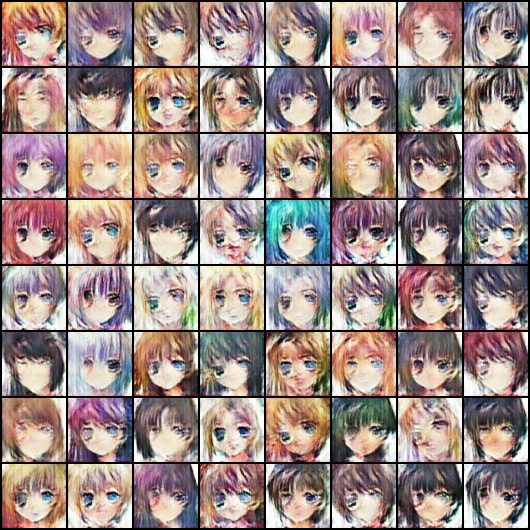

In [62]:
Image('./generated/generated-images-0005.png')

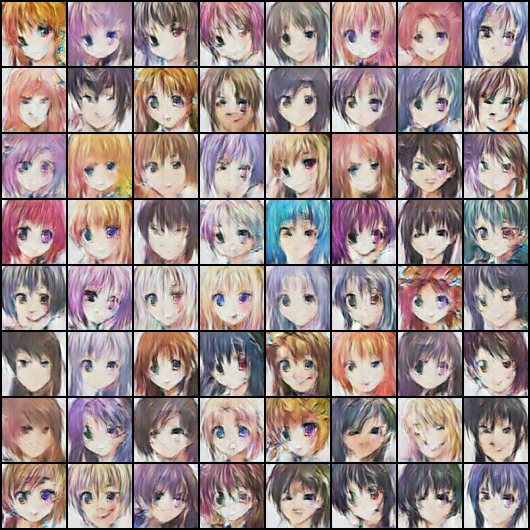

In [63]:
Image('./generated/generated-images-0010.png')

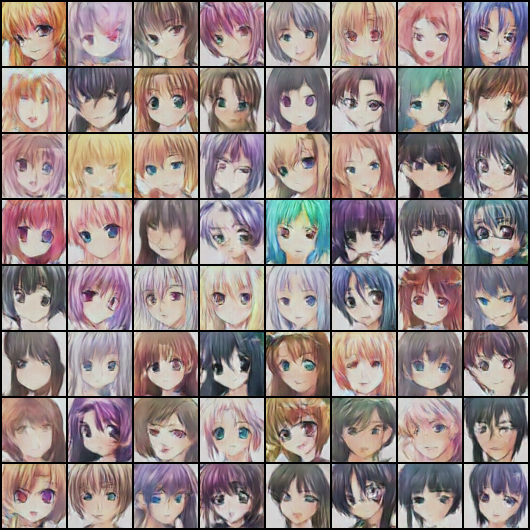

In [64]:
Image('./generated/generated-images-0020.png')

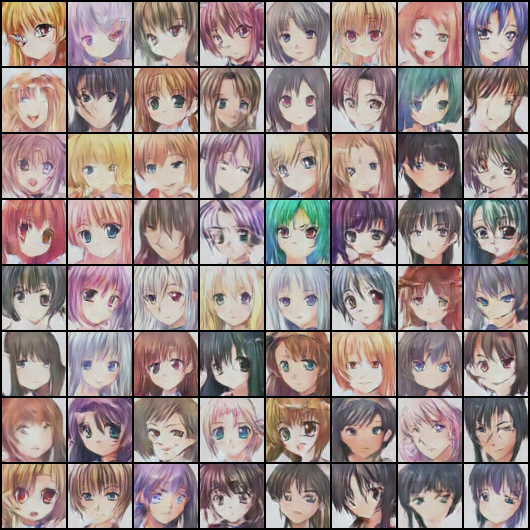

In [65]:
Image('./generated/generated-images-0025.png')

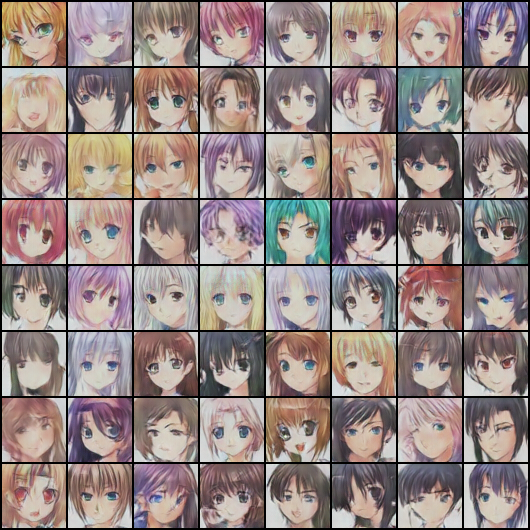

In [66]:
Image('./generated/generated-images-0035.png')

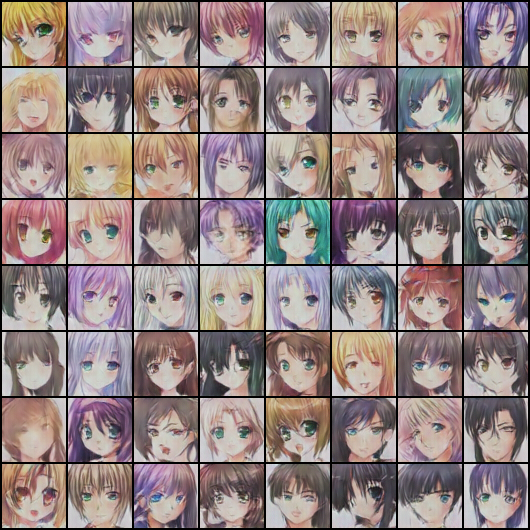

In [67]:
Image('./generated/generated-images-0040.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [73]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


It is going to take each of the images and going to convert them into the training video.

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing 
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



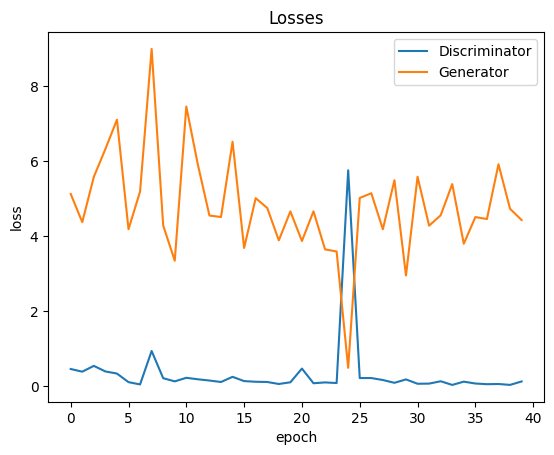

In [71]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

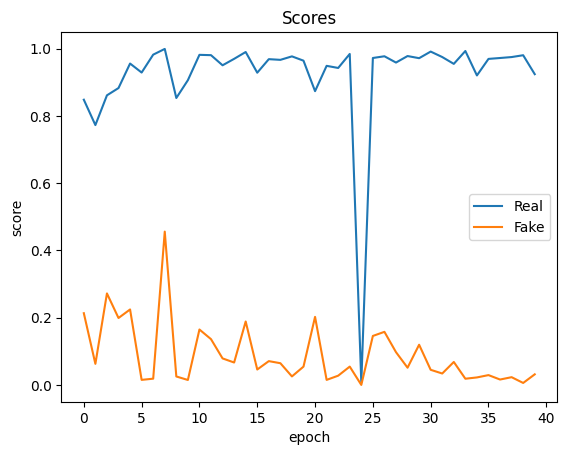

In [72]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Save and Commit

We can upload the full snapshot of this experiment to Jovian:
- Jupyter notebook
- Hyperparameters & metrics
- Models weights
- Training video